In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using ReactiveMP, GraphPPL, RxInfer, Random, Distributions, LinearAlgebra,Plots
using BenchmarkTools
import KernelFunctions: Matern52Kernel, with_lengthscale

In [3]:
Random.seed!(3)
xmin, xmax = -3, 3  # Bounds of the data
N = 200# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

k_func(θ) =  with_lengthscale(Matern52Kernel(),θ) 
meanfunc   = (x) -> 0.0;
θ_init = 1.0 #our initial lengthscale
log_θ_init = log(θ_init)

cov_strategy = CovarianceMatrixStrategy(FITC(50))  # 10 is the number of inducing points

CovarianceMatrixStrategy{FullyIndependentTrainingConditional{MersenneTwister}}(FullyIndependentTrainingConditional{MersenneTwister}(50, MersenneTwister(1), [1.0;;], [1.0;;], [1.0;;], [1.0;;], [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [4]:
# # test new thing
# @model function gp_regress(n,kernelfunc,meanfunc,train,test,strategy,log_θ)
#     y = datavar(Float64,n)
#     x = randomprocess(test,train,strategy)
#     ### change here 
#     x ~ GaussianProcess(meanfunc,kernelfunc, log_θ)
#     #######
#     γ ~ GammaShapeRate(.01,0.01)
#     for i=1:n 
#         y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i)}
#     end
# end

# @constraints function gpconstraints()   
#     q(x,γ) = q(x)q(γ)
# end

In [4]:
@model function gp_regress(n,kernelfunc,meanfunc,train,test,log_θ,strategy)
    y = datavar(Float64,n)
    x = randomprocess(test,train, strategy)

    x ~ GaussianProcess(meanfunc,kernelfunc, log_θ)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, 50) where {meta=ProcessMeta(i)}
    end
end

In [5]:
nits = 1
iresult = inference(
    model = gp_regress(length(ytrain), k_func, meanfunc, xtrain,xtest,log_θ_init, cov_strategy),
    # initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    # constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    showprogress = true
)

Inference results:
  Posteriors       | available for (x)


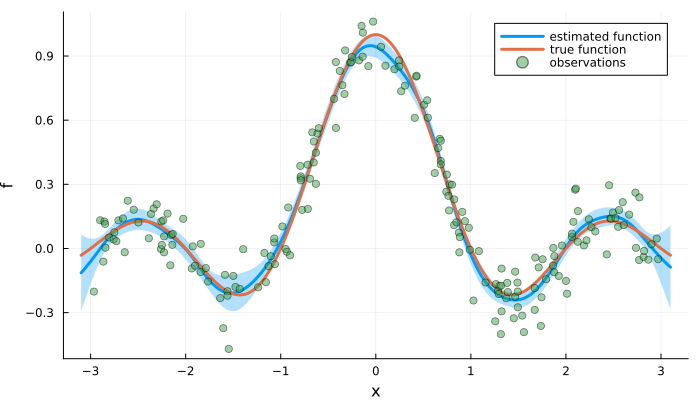

In [6]:
#FITC formula
plot(xtest,mean(iresult.posteriors[:x][end].data.finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].data.finitemarginal))),linewidth=3.0,label="estimated function",fillalpha=0.3, size=(700,400))
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5, label="observations")
xlabel!("x")
ylabel!("f")

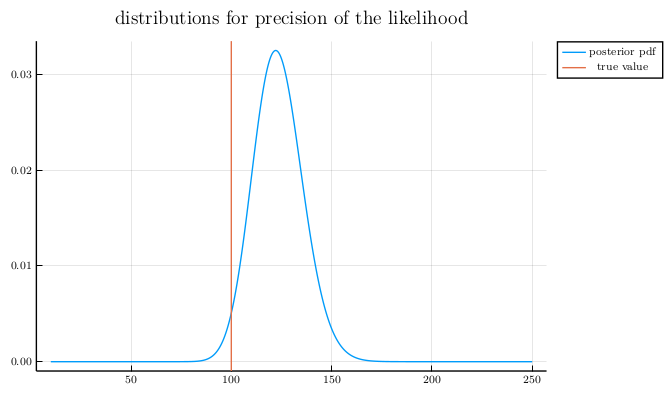

In [8]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)

In [9]:
#After improvement 
@benchmark inference(
    model = gp_regress(length($ytrain), $k_func, $meanfunc, $xtrain,$xtest,$cov_strategy, $log_θ_init),
    initmarginals = (γ = GammaShapeRate(0.01,0.01),),
    constraints = gpconstraints(),
    iterations = $nits,  
    data  = (y = $ytrain,)
)

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  191.171 ms … 236.422 ms  ┊ GC (min … max): 3.33% … 6.57%
 Time  (median):     203.018 ms               ┊ GC (median):    5.50%
 Time  (mean ± σ):   206.083 ms ±  11.704 ms  ┊ GC (mean ± σ):  5.31% ± 1.57%

          ▃    ▃ ▃  █▃                                           
  ▇▁▁▇▁▇▁▇█▁▁▇▇█▇█▇▁██▁▇▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▇▁▁▇▁▁▁▁▁▁▇▁▁▁▁▁▇ ▁
  191 ms           Histogram: frequency by time          236 ms <

 Memory estimate: 329.28 MiB, allocs estimate: 212250.

In [ ]:
# BenchmarkTools.Trial: 23 samples with 1 evaluation.
#  Range (min … max):  210.500 ms … 238.624 ms  ┊ GC (min … max): 5.24% … 5.00%
#  Time  (median):     215.284 ms               ┊ GC (median):    6.00%
#  Time  (mean ± σ):   219.776 ms ±   9.557 ms  ┊ GC (mean ± σ):  5.93% ± 0.70%

#       ▃▃█                                                        
#   ▇▁▇▇███▁▇▁▇▇▇▇▁▁▁▁▁▇▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▇▁▁▁▁▁▁▁▁▇▁▇▁▇▁▁▇ ▁
#   210 ms           Histogram: frequency by time          239 ms <

#  Memory estimate: 388.57 MiB, allocs estimate: 212450.

In [ ]:
# BenchmarkTools.Trial: 25 samples with 1 evaluation.
#  Range (min … max):  191.171 ms … 236.422 ms  ┊ GC (min … max): 3.33% … 6.57%
#  Time  (median):     203.018 ms               ┊ GC (median):    5.50%
#  Time  (mean ± σ):   206.083 ms ±  11.704 ms  ┊ GC (mean ± σ):  5.31% ± 1.57%

#           ▃    ▃ ▃  █▃                                           
#   ▇▁▁▇▁▇▁▇█▁▁▇▇█▇█▇▁██▁▇▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▇▁▁▇▁▁▁▁▁▁▇▁▁▁▁▁▇ ▁
#   191 ms           Histogram: frequency by time          236 ms <

#  Memory estimate: 329.28 MiB, allocs estimate: 212250.